### I. Setup

In [ ]:
import os
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 1500)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### II. Read Data

In [ ]:
data_dir = "/content/drive/My Drive/BST263 Final Project/UCI HAR Dataset/"
X_train_path = data_dir+'train/X_train.txt'
y_train_path = data_dir+'train/y_train.txt'
X_test_path = data_dir+'test/X_test.txt'
y_test_path = data_dir+'test/y_test.txt'

labels = ['Walking', 'Walking Upstairs', 'Walking DownStairs', 'Sitting', 
          'Standing', 'Laying']

In [ ]:
def read_data(path):
  f = open(path , 'r')
  l = np.array([ line.split() for line in f])
  return l

In [ ]:
feature_map = open(data_dir+'features.txt', 'r').readlines()
feature_map = {x.split()[0]: x.split()[1] for x in feature_map}

X_train = read_data(X_train_path).astype('float')
y_train = read_data(y_train_path)

X_test = read_data(X_test_path).astype('float')
y_test = read_data(y_test_path)

# Reshape labels
y_train = y_train.reshape(y_train.shape[0], )
y_test = y_test.reshape(y_test.shape[0], )

# Convert to integers (Needed for XGBoost)
y_train = y_train.astype('int')-1 # zero index
y_test = y_test.astype('int')-1 # zero index


In [ ]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(7352, 561)
(2947, 561)
(7352,)
(2947,)


### Visualize Signals

In [ ]:
train_id = read_data(os.path.join(data_dir, 'train/subject_train.txt'))
train_id = np.concatenate(train_id.astype('int'))

df_meta = pd.DataFrame({'subject': train_id, 
                        'activity_label': y_train})

# 346 windows per subj with 128 data pts per window [@ 50 Hz = 2.56 sec]
raw_data_path = os.path.join(data_dir, 'train/Inertial Signals/')

def load_data_file(file_path):
    dat = pd.read_csv(file_path, delim_whitespace = True, header = None)
    return dat.values

def load_all_data(dir_path):

    body_gyro = []
    body_acc = []
    total_acc = []

    for file in sorted(os.listdir(dir_path)): #xyz ordered
        m = re.match('^body_gyro*', file)
        if m:
            body_gyro.append(load_data_file(os.path.join(dir_path, file)))
            continue
        m = re.match('^body_acc*', file)
        if m:
            body_acc.append(load_data_file(os.path.join(dir_path, file)))
            continue
        m = re.match('^total_acc*', file)
        if m:
            total_acc.append(load_data_file(os.path.join(dir_path, file)))
            continue
    
    return({'Body Gyroscope': np.dstack(body_gyro), 
            'Body Acceleration': np.dstack(body_acc),
            'Total Acceleration': np.dstack(total_acc) })
    

data_dict = load_all_data(raw_data_path)

In [ ]:
labels = { 0: 'walk', 1: 'walk up', 2: 'walk down',
           3: 'sit', 4: 'stand', 5: 'lay'}

# subj repeats each activity -> label 1st and last occurence on plot
act = df_meta[df_meta.subject == 1].reset_index().groupby('activity_label').index.min().to_frame() 
act2 = df_meta[df_meta.subject == 1].reset_index().groupby('activity_label').index.max()  
act2 = act2.to_frame()
act = pd.concat([act, act2], axis = 0)
act['label'] = act.index.map(lambda x: labels[x])
act['minute'] = act['index'].map(lambda x: x*128/56/60)
act = act.sort_values('minute').reset_index()

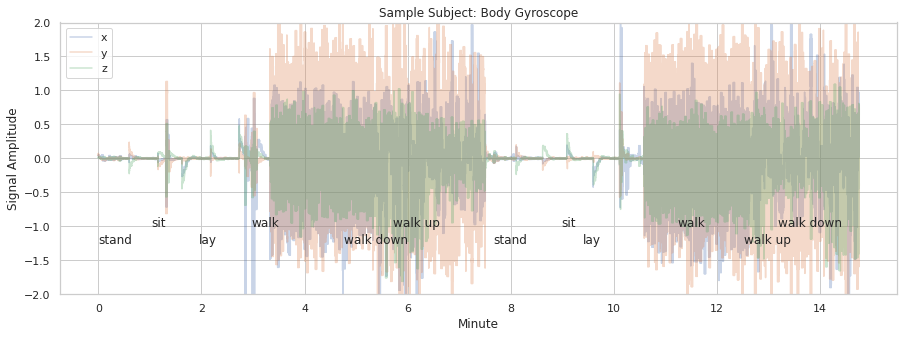

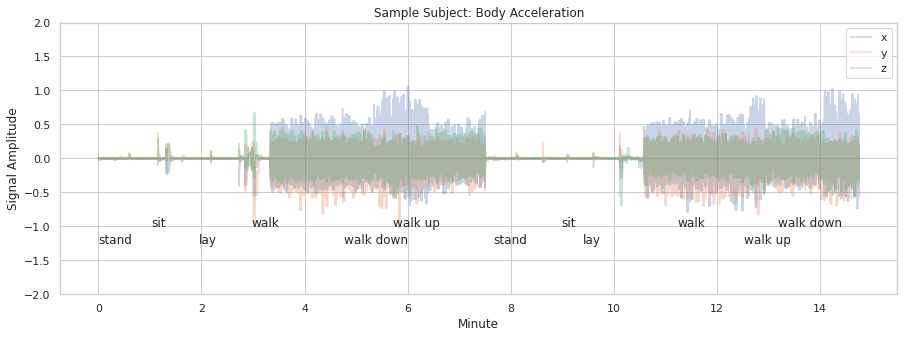

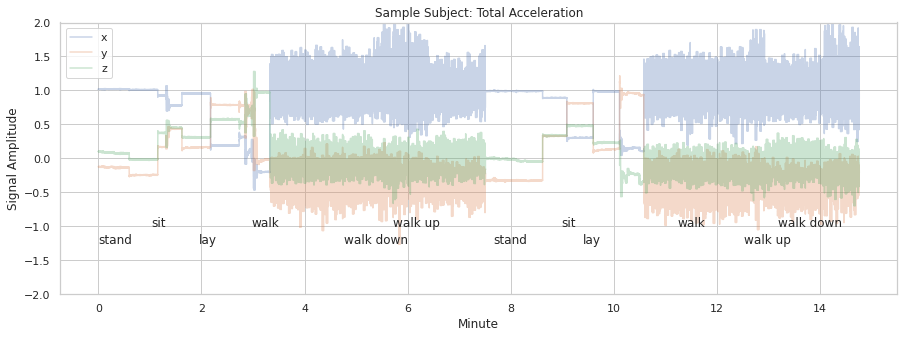

In [ ]:
for label, data in data_dict.items():
    s1_data = data[0:346].reshape(128*346, 3) # flatten across subj 1 data
    _df = pd.DataFrame(s1_data, columns = ['x', 'y', 'z'])
    _df.index = _df.index/50/60 # index per min
    _df.plot(alpha = 0.3, figsize  = (15,5))
    plt.xlabel('Minute')
    plt.ylabel('Signal Amplitude')
    plt.title('Sample Subject: ' + label)
    plt.ylim(-2,2)
    for i, row in act.iterrows():
        if i%2:
          y = -1
        else:
          y = -1.25 
        plt.text(row.minute, y, row.label)

### III. PCA

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train)

In [ ]:
print(np.sum(pca.explained_variance_ratio_)) # 67% of the variability in the data explained by the first two prinicipal components

0.6746746270487924


In [ ]:
colors = np.array([int(y) for y in y_train])
labels = {0: 'WALKING',1: 'WALKING_UPSTAIRS',2: 'WALKING_DOWNSTAIRS',3: 'SITTING',4: 'STANDING',5: 'LAYING'}

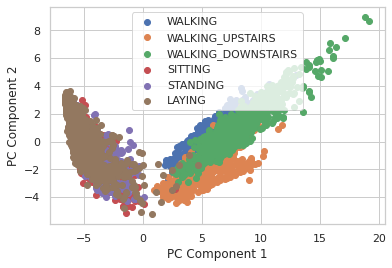

In [ ]:
# Visulize first two PCA components
plt.figure()
for l in labels:
  grp = np.where(colors == l)
  plt.scatter(pca_result[grp, 0], pca_result[grp,1],label = labels[l])
plt.xlabel('PC Component 1')
plt.ylabel('PC Component 2')
plt.legend()
plt.show()


# IV. Models

## Baseline (Linear Discriminant Analysis)



In [ ]:
scaler = StandardScaler()
sc_x_train = scaler.fit_transform(X_train)
sc_x_test = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis()
lda.fit(sc_x_train, y_train)

y_pred = lda.predict(sc_x_test)

### Results

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('The accuracy score of the LDA model is: ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('The f1 score of the LDA model is: ', f1)

The accuracy score of the LDA model is:  0.9623345775364778
The f1 score of the LDA model is:  0.962618180402033


We tried applying PCA (with varying numbers of Principle Components) on the training set but it did not improve results. LDA itself can be used for dimensionality reducton, so this result was not too surprising. LDA also internally scales the data, so explicit preprocessing was not required for this.

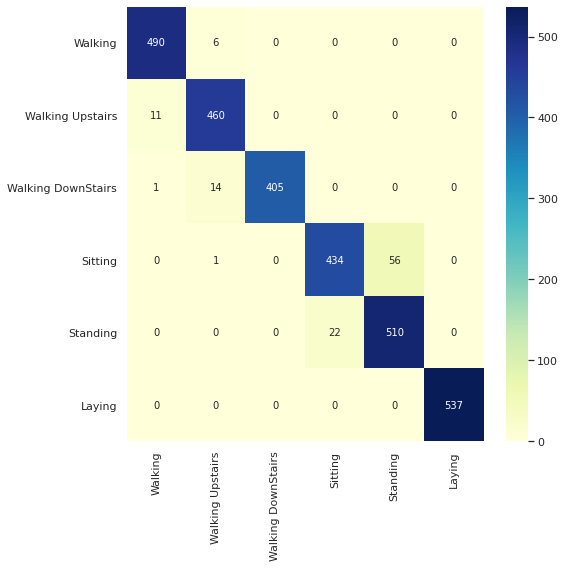

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (8,8))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", fmt='g')

In [ ]:
coefficients = np.sum(np.abs(lda.coef_), axis=0)
coefficients = pd.DataFrame(coefficients, index=feature_map.values())

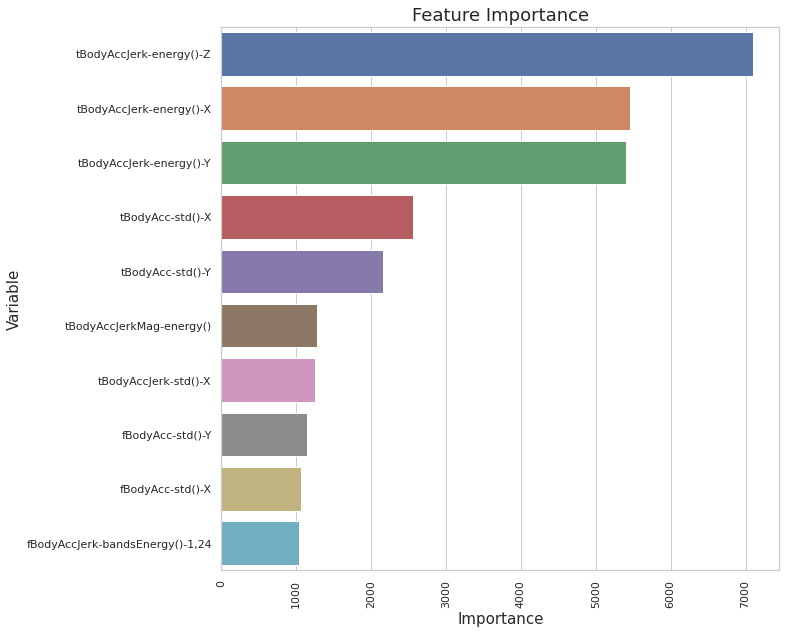

In [ ]:
top_features = coefficients[0].sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 10))

ax = sns.barplot(x=0, y='index', data=top_features, orient='h')
ax.set_xlabel("Importance", fontsize=15)
ax.set_ylabel("Variable", fontsize=15)
ax.set_title("Feature Importance", fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Note: The feature importance here is a summation of the absolute values of the coefficients of each variable across the classes. We can thus seen that the predictive power quickly decreases after the top 3 features.

## KNN

Fit KNN Model (Unscaled Data)

In [ ]:
# # range of k we want to try
# k_range = range(1, 31)

# # empty list to store scores
# k_scores = []

# # 1. we will loop through reasonable values of k
# for k in k_range:
#     print(k)
#     # 2. run KNeighborsClassifier with k neighbours
#     knn = KNeighborsClassifier(n_neighbors=k)
#     # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
#     scores = cross_val_score(knn,train_x, y_train, cv=10, scoring='accuracy')
#     # 4. append mean of scores for k neighbors to k_scores list
#     k_scores.append(scores.mean())

Text(0, 0.5, 'Cross-validated accuracy')

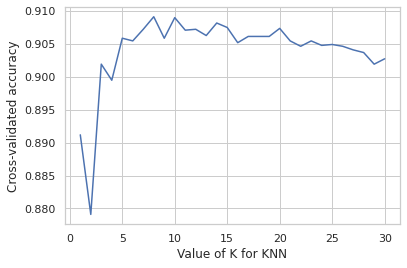

In [ ]:
k_range = range(1, 31)
k_scores= [0.8911930641821947,
 0.8790917997633837,
 0.9019400695060632,
 0.8994925687666371,
 0.9058832446021887,
 0.9054754510499853,
 0.9072423099674654,
 0.9091478112984325,
 0.9058810263235729,
 0.9090115720201124,
 0.9071053312629399,
 0.907242125110914,
 0.9062906684412895,
 0.9081946909198461,
 0.9075136793847974,
 0.9052026027802424,
 0.906152950310559,
 0.906153504880213,
 0.9061525805974565,
 0.9073770703933747,
 0.9054726782017155,
 0.9046572759538598,
 0.9054728630582668,
 0.9047933303756285,
 0.904929199940846,
 0.9046574608104111,
 0.904112503697131,
 0.9037050798580303,
 0.901936372375037,
 0.9027530686187518]

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [ ]:
# fit for optimal k
# optimal_k = np.argmax(k_scores) + 1 # 8
optimal_k = 8

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9073634204275535

In [ ]:
f1 = f1_score(y_test, y_pred, average = 'macro')
print('The f1 score of the KNN model is: ', f1)

The f1 score of the KNN model is:  0.9044789027262965


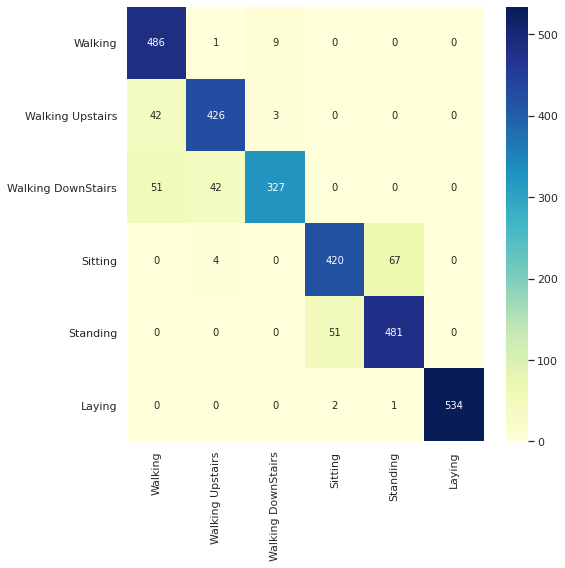

In [ ]:
import seaborn as sn
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ['Walking', 'Walking Upstairs', 'Walking DownStairs', 
                          'Sitting', 'Standing', 'Laying'],
                  columns = ['Walking', 'Walking Upstairs', 'Walking DownStairs', 
                          'Sitting', 'Standing', 'Laying'],
             )

plt.figure(figsize = (8,8))
sn.heatmap(cm_df, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", fmt = 'g')

## SVC

In [ ]:
# Grid Search
# defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# grid_svc = GridSearchCV(svm.SVC(), param_grid, refit = True, cv=10, verbose = 3)

# # run SVM with regularization paramter C and gamma
# svc_model = grid_svc.fit(X_train,  y_train)

# # print best parameter after tuning
# print(grid_svc.best_params_)
  
# # print how our model looks after hyper-parameter tuning
# print(grid_svc.best_estimator_)

In [ ]:
# fit for optimal C, gamma
optimal_c = 1000
optimal_gamma = 0.0001
svc_model = svm.SVC(C=optimal_c, gamma=optimal_gamma, kernel='rbf')
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9619952494061758

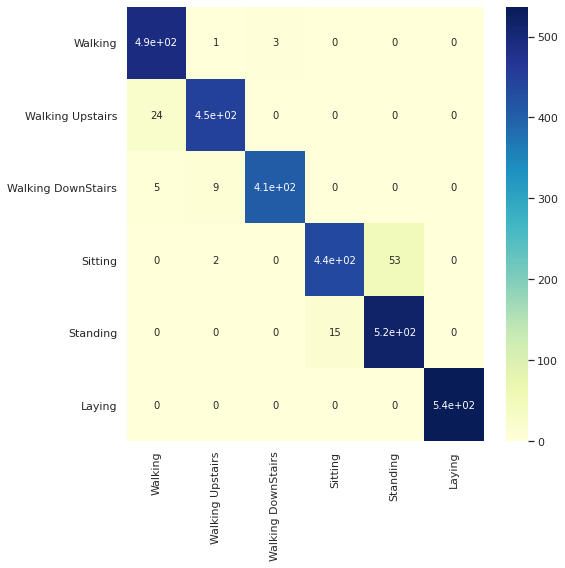

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ['Walking', 'Walking Upstairs', 'Walking DownStairs', 
                          'Sitting', 'Standing', 'Laying'],
                  columns = ['Walking', 'Walking Upstairs', 'Walking DownStairs', 
                          'Sitting', 'Standing', 'Laying'],
             )

plt.figure(figsize = (8,8))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")

In [ ]:
# average: string, [None, ‘micro’, ‘macro’, ‘samples’, ‘weighted’ (default)]
results_f1_score = f1_score(y_test, y_pred, average='weighted')
print("The F1 score for the SVM model is: ", round(results_f1_score,3))

The F1 score for the SVM model is:  0.962


/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


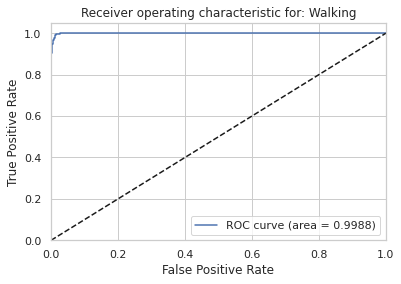

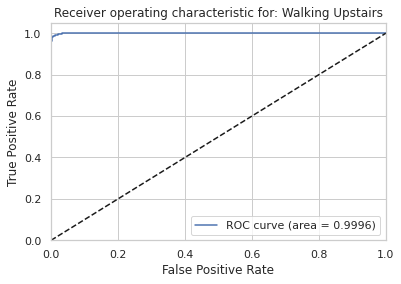

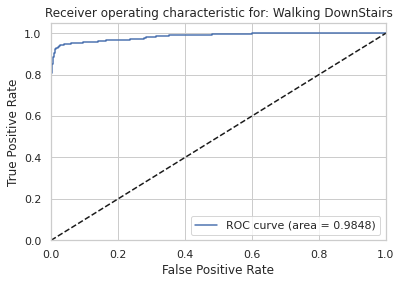

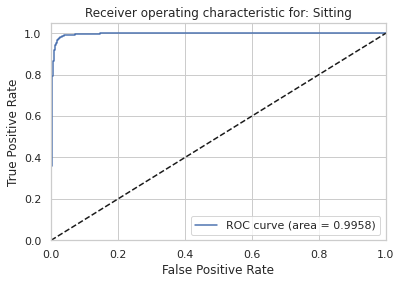

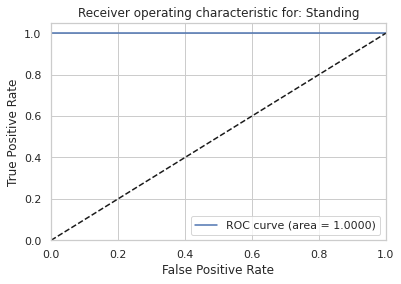

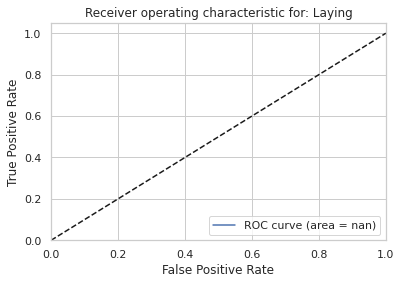

In [ ]:
#https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
#https://datascience.stackexchange.com/questions/18374/predicting-probability-from-scikit-learn-svc-decision-function-with-decision-fun
activities = ['Walking', 'Walking Upstairs', 'Walking DownStairs', 'Sitting', 'Standing', 'Laying']
y_train_binarize = label_binarize(y_train, classes=[1,2,3,4,5,6])
y_test_binarize = label_binarize(y_test, classes=[1,2,3,4,5,6])
n_classes = y_test_binarize.shape[1]

clf = OneVsRestClassifier(svm.SVC(C=optimal_c, gamma=optimal_gamma, kernel='rbf'))
y_score = clf.fit(X_train, y_train_binarize).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for: '+activities[i])
    plt.legend(loc="lower right")
    plt.show()

## XG Boost

### Hyperparameter Tuning the XGBoost model

In [ ]:
# grid_param = {
#     'learning_rate': np.linspace(0,3, num = 15),
#     'alpha': np.linspace(0,1, num = 10),
#     'max_depth': np.linspace(5, 100, num = 11).astype(int)
# }
# other_params = {
#     'max_depth': 2, 
#     'objective': 'multi:softmax', 
#     'num_class':6, 'nthread': 4, 
#     'eval_metric': 'mlogloss',
#     'n_jobs':-1,
#     'verbosity': 2}

# rand_sr = RandomizedSearchCV(estimator = xgb.XGBClassifier(**other_params), 
#                                param_distributions = grid_param, 
#                                cv = 3, n_jobs = -1)
# rand_sr.fit(X_train, y_train)

Best learning rate: 0.42857142857142855  
Best alpha: 0.7777777777777777  
Best max depth: 90  

### Train the Model

In [ ]:
# Use train test split to create a validation split
# X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# eta: learning rate 0.001
# alpha : L1 regularization 0
params = {
    'max_depth': 90, 
    'objective': 'multi:softmax', 
    'num_class':6, 'nthread': 4, 
    'eval_metric': 'mlogloss',
    'n_jobs':-1,
    # Tuned hyperparameters
    'learning_rate':0.42857142857142855,
    'alpha': 0.7777777777777777}

# Convert to XGB matrix
# dtrain = xgb.DMatrix(X_train_s, label=y_train_s)
dtrain = xgb.DMatrix(X_train, y_train)
# Create val set
# dval = xgb.DMatrix(X_val, label = y_val)
# evallist = [(dval, 'eval'), (dtrain, 'train')]
evallist = [(dtrain, 'train')]
num_round = 15
bst = xgb.train(params = params, dtrain = dtrain)

#### Evaluate Model

##### Feature Importance

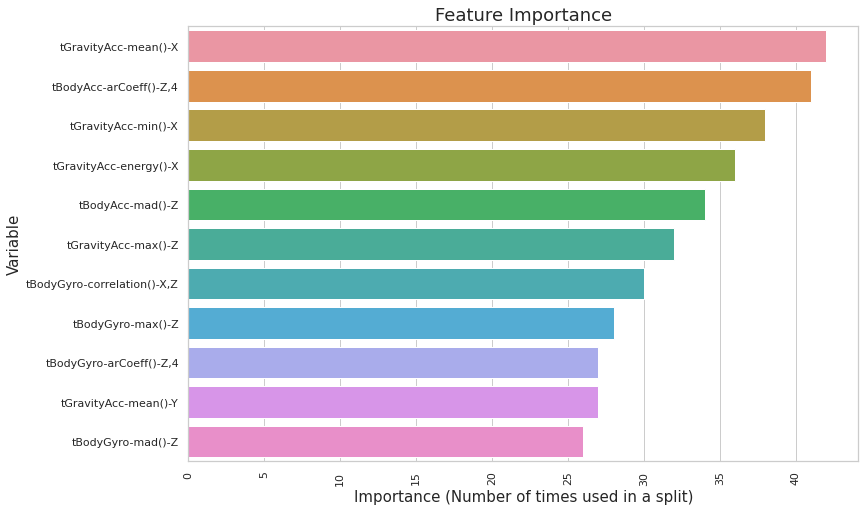

In [ ]:
# Gets the number of times a features is used to split the data across all trees
bst_gain = bst.get_score(importance_type='weight')
feature = pd.DataFrame([{'feature':k, 'num_splits':v} for k,v in bst_gain.items()])
ft_lkp = pd.DataFrame([{'feature': 'f'+k, 'name':v} for k, v in feature_map.items()])
feature = pd.merge(feature, ft_lkp, how = 'left', on = 'feature').reset_index()
feature =  feature.sort_values('num_splits', ascending=False)[0:11]

plt.figure(figsize=(12, 8))

ax = sns.barplot(x='num_splits', y='name', data=feature, orient='h')
ax.set_xlabel("Importance (Number of times used in a split)", fontsize=15)
ax.set_ylabel("Variable", fontsize=15)
ax.set_title("Feature Importance", fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

##### F1 score

In [ ]:
dtest = xgb.DMatrix(X_test)
ypred = bst.predict(dtest)
f1 = f1_score(y_test, ypred, average = 'macro')
print('The f1 score of the XGboost model is: ', f1)

The f1 score of the XGboost model is:  0.9185165627115485


In [ ]:
print(f"The train accuracy is {accuracy_score(y_train, bst.predict(dtrain))}")
print(f"The test accuracy is {round(accuracy_score(y_test, ypred),4)}")

The train accuracy is 1.0
The test accuracy is 0.9192


##### Confusion Matrix

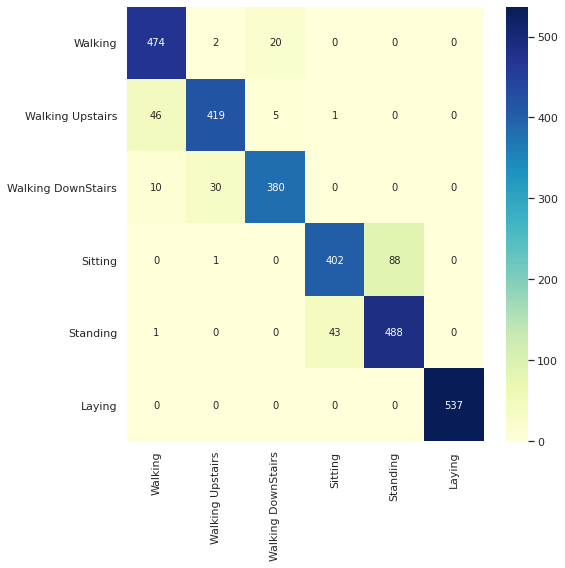

In [ ]:
cm = confusion_matrix(y_test, ypred)
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (8,8))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", fmt='g')

## Random Forest

### III. Hyperparameter Tuning Random Forest model

In [ ]:
# # Grid Search CV
# # tutorial : https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/

# ########Retune random forest model 
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
# # Number of features to consider at every split
# max_features = [int(np.sqrt(X_train.shape[1])), int(np.log2(X_train.shape[1]))]
# # log 2 
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'bootstrap': bootstrap}
# #Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# ### ADD neg_mean_error
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, verbose=100, random_state=42, n_jobs = -1)


In [ ]:
#rf_random

In [ ]:
# Fitting
#rf_random.fit(X_train, y_train)

In [ ]:
# Best parameters
# rf_args = rf_random.best_params_
# rf_random.best_params_

### III(B) Cross Validation Analysis

In [ ]:
# # Save cross valdiation results across grid search parameters to file
# cv_result=pd.DataFrame.from_dict(rf_random.cv_results_,orient="index")


# # Plot parameters with validation R square 
# plot=cv_result.sort_values(axis=1,by=['param_n_estimators'])

# # Plot number of parameters with validation R square 

# est=sns.boxplot(plot.loc['param_n_estimators',],plot.loc['mean_test_score',])
# est.set_xlabel("Number of estimators")
# est.set_ylabel("Validation R squared (3-fold CV)")

# plt.setp(est.get_xticklabels(), rotation=90)
# plt.title("Figure 18 - Validataion R Squared with Number of Estimators")
# plt.show()


In [ ]:
# ##Plot depths of tree with validation R square 
# plot=cv_result.sort_values(axis=1,by=['param_max_depth'])

# est=sns.boxplot(plot.loc['param_max_depth',],plot.loc['mean_test_score',])
# est.set_xlabel("Max depth")
# est.set_ylabel("Validation R squared (3-fold CV)")
# plt.title("Figure 19 - Validataion R Squared with Max Depth")
# plt.show()


In [ ]:
# # Plotting Max Features 
# plot=cv_result.sort_values(axis=1,by=['param_max_features'])
# est=sns.boxplot((plot.loc['param_max_features',]),plot.loc['mean_test_score',])
# est.set_xlabel("Max features")
# est.set_ylabel("Validation R squared (3-fold CV)")

# plt.title("Figure 20 - Validataion R Squared with Max Features")
# plt.show()

### IV. Train final model with hyperparameters tuned

In [ ]:
column_names = pd.Series(feature_map)
X_train = pd.DataFrame(X_train)
X_train.columns = column_names
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [ ]:
# Train final model
rf_args = {'bootstrap': True, 'max_depth': 81, 'max_features': 9, 'n_estimators': 540}

# 
column_names = pd.Series(feature_map)
X_train = pd.DataFrame(X_train)

# Use train test split to create a validation split
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

bestrf=RandomForestClassifier(**rf_args)
rf_best = bestrf.fit(X_train,y_train)

In [ ]:
#rf_best = bestrf.fit(X_train_s,y_train_s)

### V. Evaluate Model

In [ ]:
print(f"The train accuracy is {rf_best.score(X_train, y_train)}")
print(f"The test accuracy is {round(rf_best.score(X_test, y_test),4)}")

The train accuracy is 1.0
The test accuracy is 0.9393


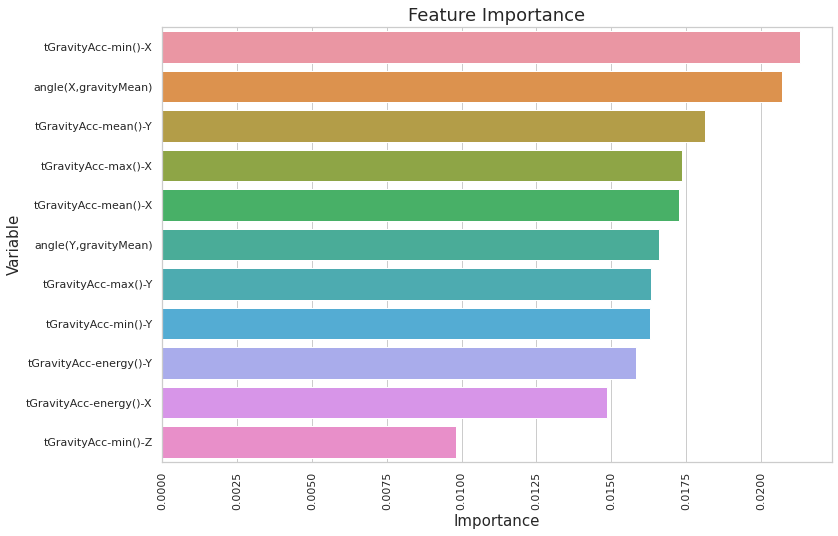

In [ ]:
feature = pd.DataFrame(rf_best.feature_importances_)
feature['name'] = X_train_s.columns

feature =  feature.sort_values(0, ascending=False)[0:11]

plt.figure(figsize=(12, 8))

ax = sns.barplot(x=0, y='name', data=feature, orient='h')
ax.set_xlabel("Importance", fontsize=15)
ax.set_ylabel("Variable", fontsize=15)
ax.set_title("Feature Importance", fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
# Macro from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html:
# Calculate metrics for each label, and find their unweighted mean. 
# This does not take label imbalance into account.

# Prediction
y_pred = rf_best.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average = 'macro'),4)
print('The f1 score of the Random Forrest model is: ', f1)

The f1 score of the Random Forrest model is:  0.9366


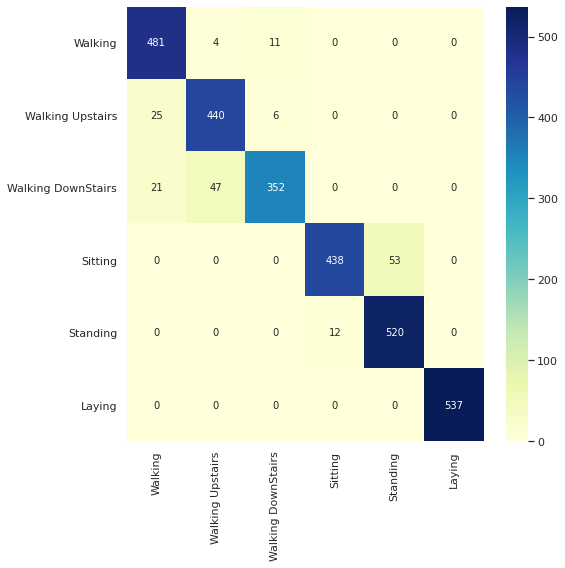

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (8,8))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", fmt='g')